In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import pandas as pd
import torch

from src import get_device, read_dicom, Detector, Siddon
from src.metrics import xcorr2

device = get_device("cuda")

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
# colors = ["#e7298a", "#1b9e77", "#d95f02", "#7570b3"]
colors = {"pink": "#e7298a", "purple": "#7570b3"}

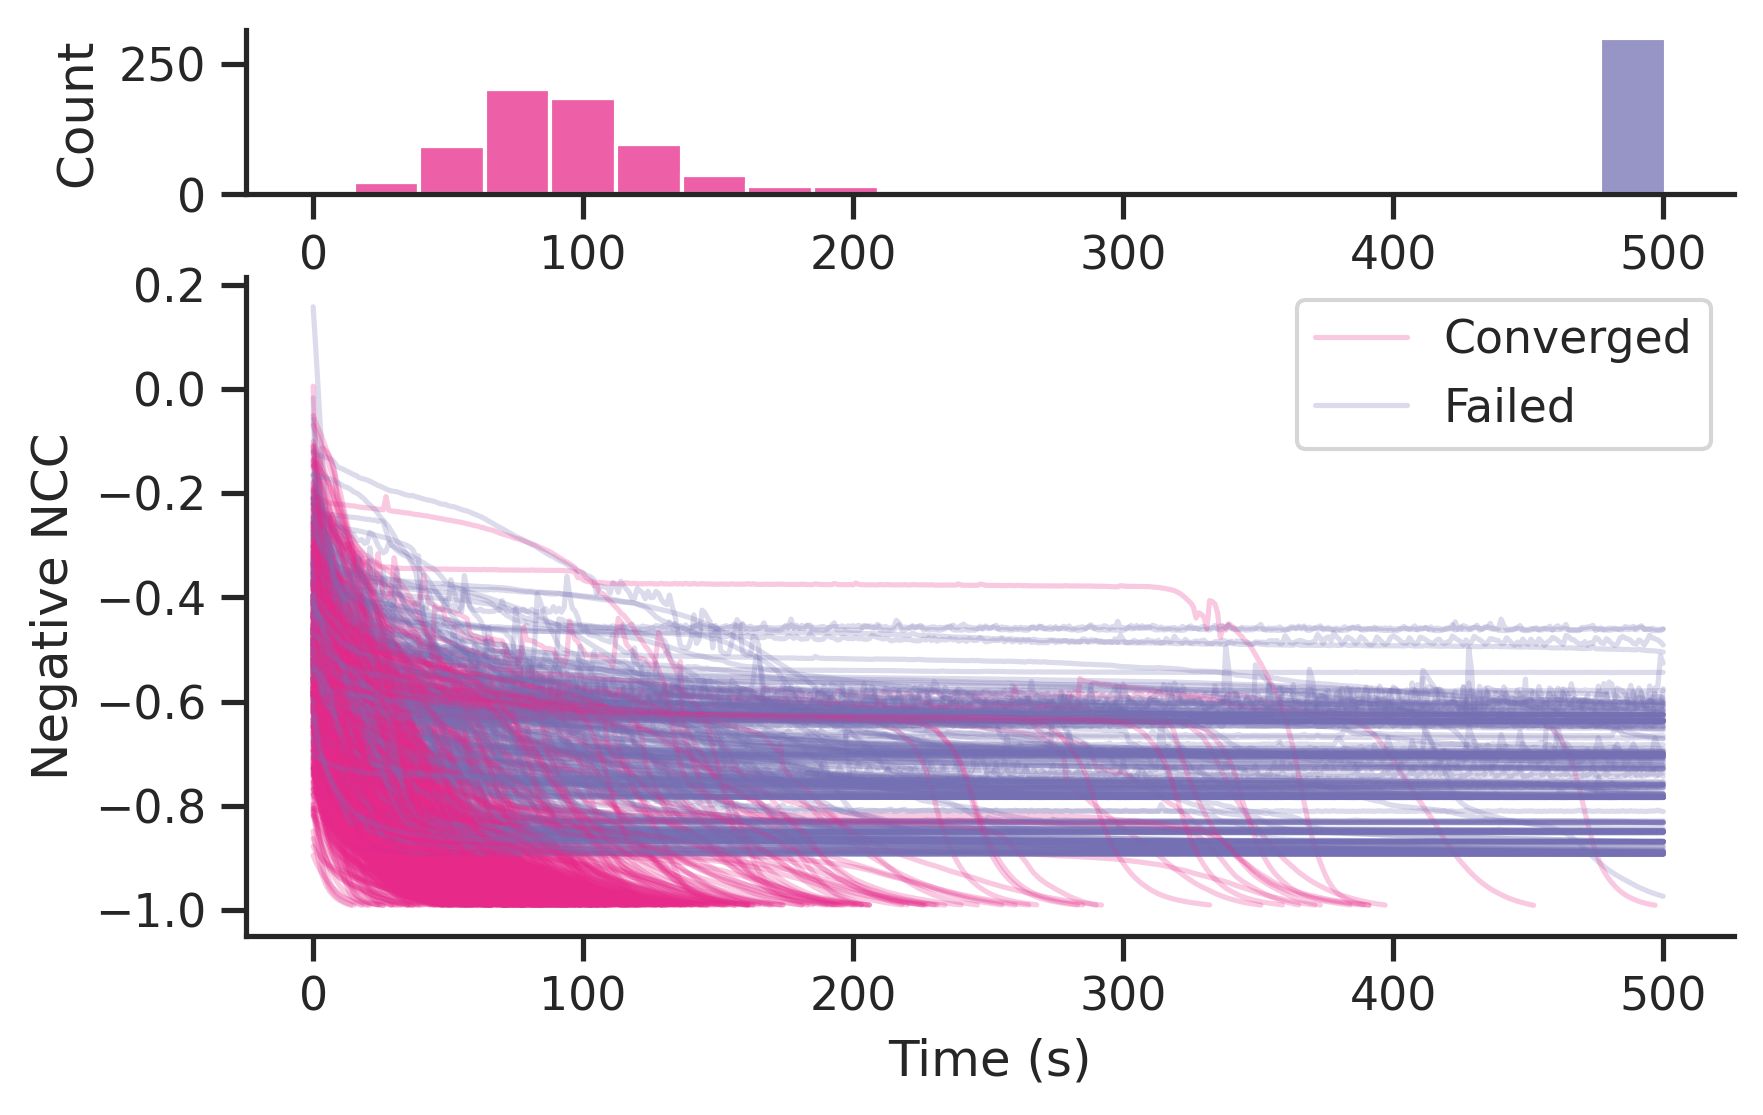

In [3]:
fig = plt.figure(dpi=300, figsize=plt.figaspect(5/8))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 4], figure=fig)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

conv = 0
nconv = 0
output = []

### Plot the training curves
label_converged = True
label_failed = True
kwargs = {"alpha": 0.25, "lw": 1.25}

for csv in Path("../results/iterations/").glob("*.csv"):
    
    df = pd.read_csv(csv, comment="#")
    n = len(df)
    converged = True if n < 500 else False
    
    if converged:
        conv += 1
        label = "Converged"
        ax2.plot(df["itr"], df["loss"], c=colors["pink"], label=label if label_converged else None, **kwargs)
        label_converged = False
    else:
        nconv += 1
        label = "Failed"
        ax2.plot(df["itr"], df["loss"], c=colors["purple"], label=label if label_failed else None, **kwargs)
        label_failed = False
    
    initial_loss = df["loss"].iloc[0]
    final_loss = df["loss"].iloc[-1]
    output.append([converged, n, initial_loss, final_loss, csv])
    ax2.set(xlabel="Time (s)", ylabel="Negative NCC")
    ax2.set_xticks([0, 100, 200, 300, 400, 500])
    ax2.set_xticklabels([0, 3, 6, 9, 12, 15])

ax2.legend()

### Plot the number of iterations
df = pd.DataFrame(output, columns=["converged", "n_iters", "initial_loss", "final_loss", "filename"])
sns.histplot(data=df, x="n_iters", palette=[colors["purple"], colors["pink"]], hue="converged", legend=False, ax=ax1, bins=20, multiple="stack")
ax1.set(xlabel="# Iterations until convergence")
ax1.set_xticklabels([0, 100, 200, 300, 400, 500])

plt.savefig("../figures/optimization.pdf", bbox_inches="tight")
plt.show()

In [4]:
df["converged"].summary()

AttributeError: 'Series' object has no attribute 'summary'

In [5]:
df["converged"].sum() / len(df)

0.701

In [14]:
df["converged"].sum()

701

In [15]:
(1 - df["converged"]).sum()

299

In [34]:
# Remove right KDE
# Add time to histogram plot

In [63]:
df[df["converged"] == True].n_iters.mean()

104.17190388170056

In [64]:
df[df["converged"] == True].n_iters.std()

60.51129390971389

## Make DRRs

In [37]:
volume, spacing = read_dicom("../data/cxr/")
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

# def make_drr(theta, phi, gamma, bx, by, bz, sdr=200., height=300, delx=1.75e-2):
def make_drr(theta, phi, gamma, bx, by, bz, sdr=200., height=200, delx=2.5e-2):
    """Detector parameters -> DRR"""
    detector = Detector(
        sdr    = sdr,
        theta  = theta,
        phi    = phi,
        gamma  = gamma,
        bx     = bx,
        by     = by,
        bz     = bz,
        device = device
    )
    source, rays = detector.make_xrays(height, height, delx, delx)
    drr = siddon.raytrace(source, rays)
    return drr, detector.angles, detector.translation

def plot(drr):
    plt.imshow(drr.detach().cpu(), cmap="gray")
    plt.show()
    
def corr(drr, est):
    x = xcorr2()
    loss = x(drr.expand(1, 1, -1, -1), est.expand(1, 1, -1, -1))
    return loss.item()

In [45]:
def plot_est(filename, intermediate_idx, out):
    
    fig, axs = plt.subplots(ncols=4, figsize=plt.figaspect(1/4), dpi=300)
    
    # Ground truth DRR
    theta = torch.pi
    phi = 0
    gamma = torch.pi / 2
    bx = 180
    by = 180
    bz = 166.25
    drr, _, _ = make_drr(theta, phi, gamma, bx, by, bz)
    axs[3].imshow(drr.detach().cpu(), cmap="gray")
    axs[3].set(xticks=[], yticks=[], title="Ground Truth\n")
    
    # Plot initial
    with open(filename, "r") as f:
        params = f.readline()[2:-2]
        t, p, g, x, y, z = [float(param) for param in params.split(",")]
        est, _, _ = make_drr(t, p, g, x, y, z)
        axs[0].imshow(est.detach().cpu(), cmap="gray")
        axs[0].set(title=f"Initial\n-NCC = {-corr(drr,est):.2f}")
        axs[0].set(xticks=[], yticks=[])
        
    # Plot intermediate
    df = pd.read_csv(filename, comment="#")
    t, p, g, x, y, z = df.iloc[intermediate_idx][2:].values
    t += theta
    p += phi
    g += gamma
    x += bx
    y += by
    z += bz
    est, _, _ = make_drr(t, p, g, x, y, z)
    axs[1].imshow(est.detach().cpu(), cmap="gray")
    axs[1].set(title=f"Intermediate\n-NCC = {-corr(drr,est):.2f}")
    axs[1].set(xticks=[], yticks=[])
     
    # Plot last
    t, p, g, x, y, z = df.iloc[-1][2:].values
    t += theta
    p += phi
    g += gamma
    x += bx
    y += by
    z += bz
    est, _, _ = make_drr(t, p, g, x, y, z)
    axs[2].imshow(est.detach().cpu(), cmap="gray")
    axs[2].set(title=f"Final\n-NCC = {-corr(drr,est):.2f}")
    axs[2].set(xticks=[], yticks=[])
    
    plt.savefig(out, bbox_inches="tight")
    plt.show()
    
    del drr, est

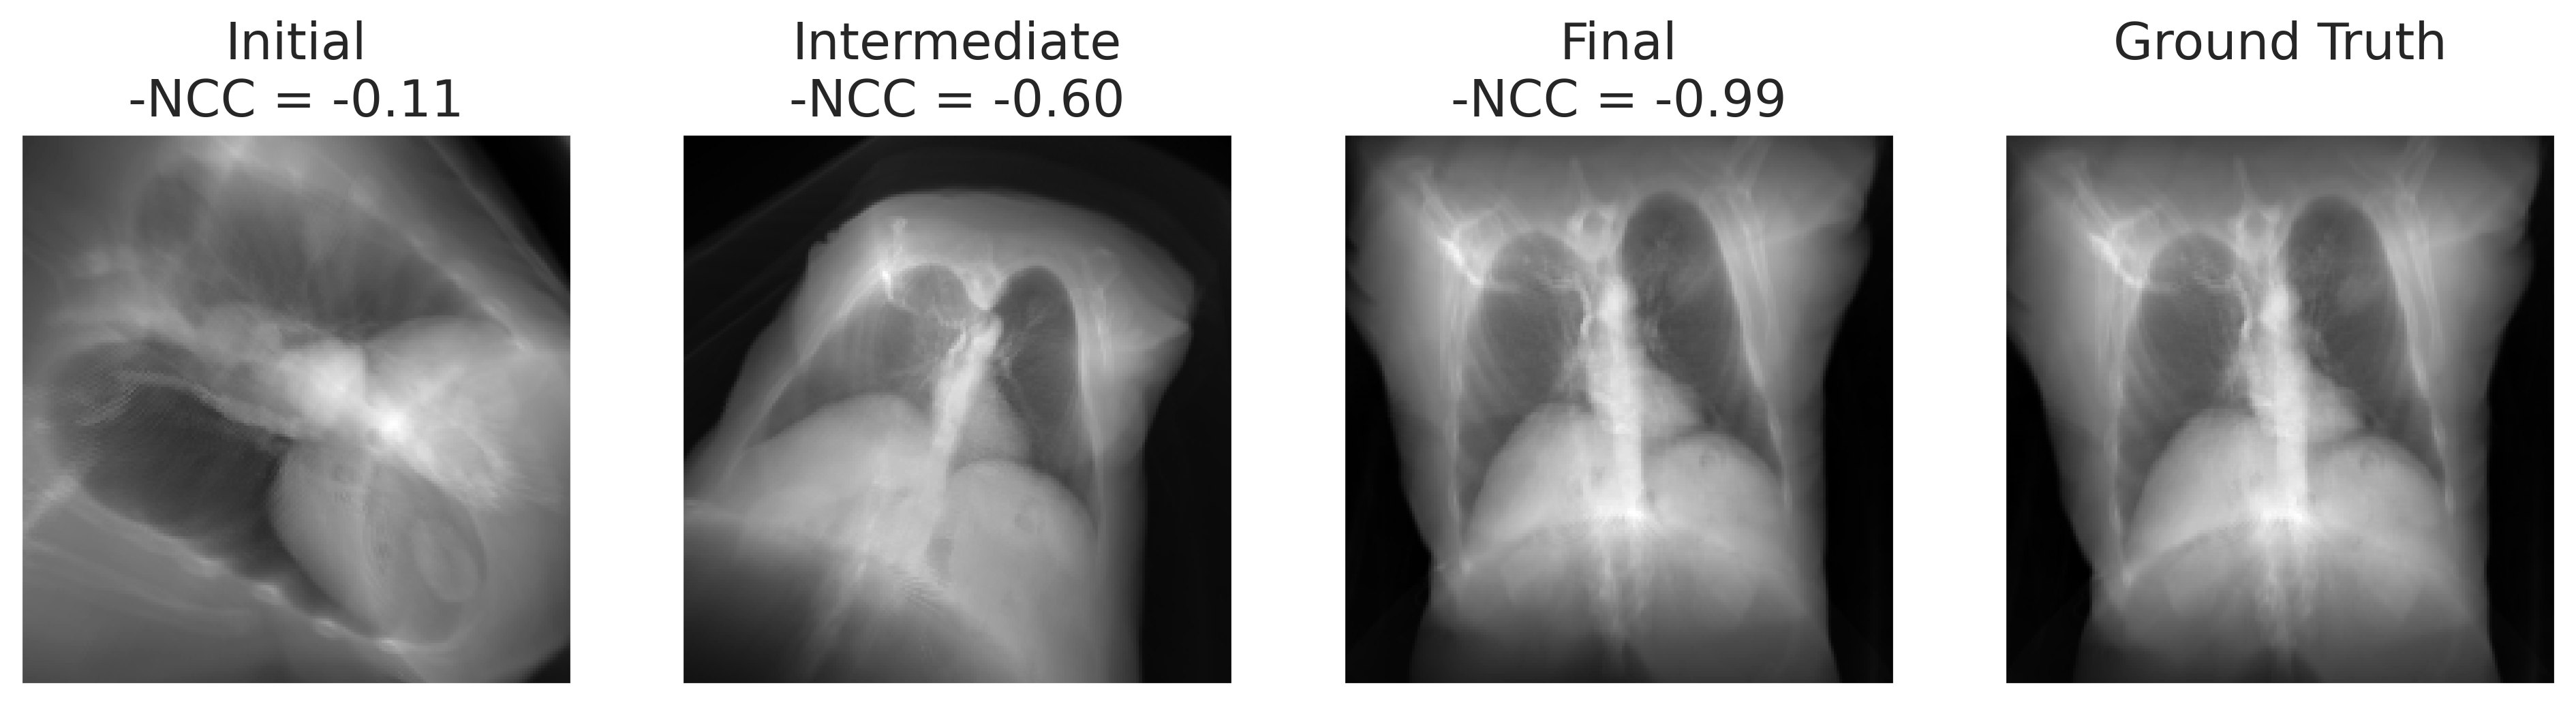

In [46]:
sns.set(font_scale=1.5)
plot_est("../results/grad_desc/300.csv", 25, "../figures/converged-1.pdf")

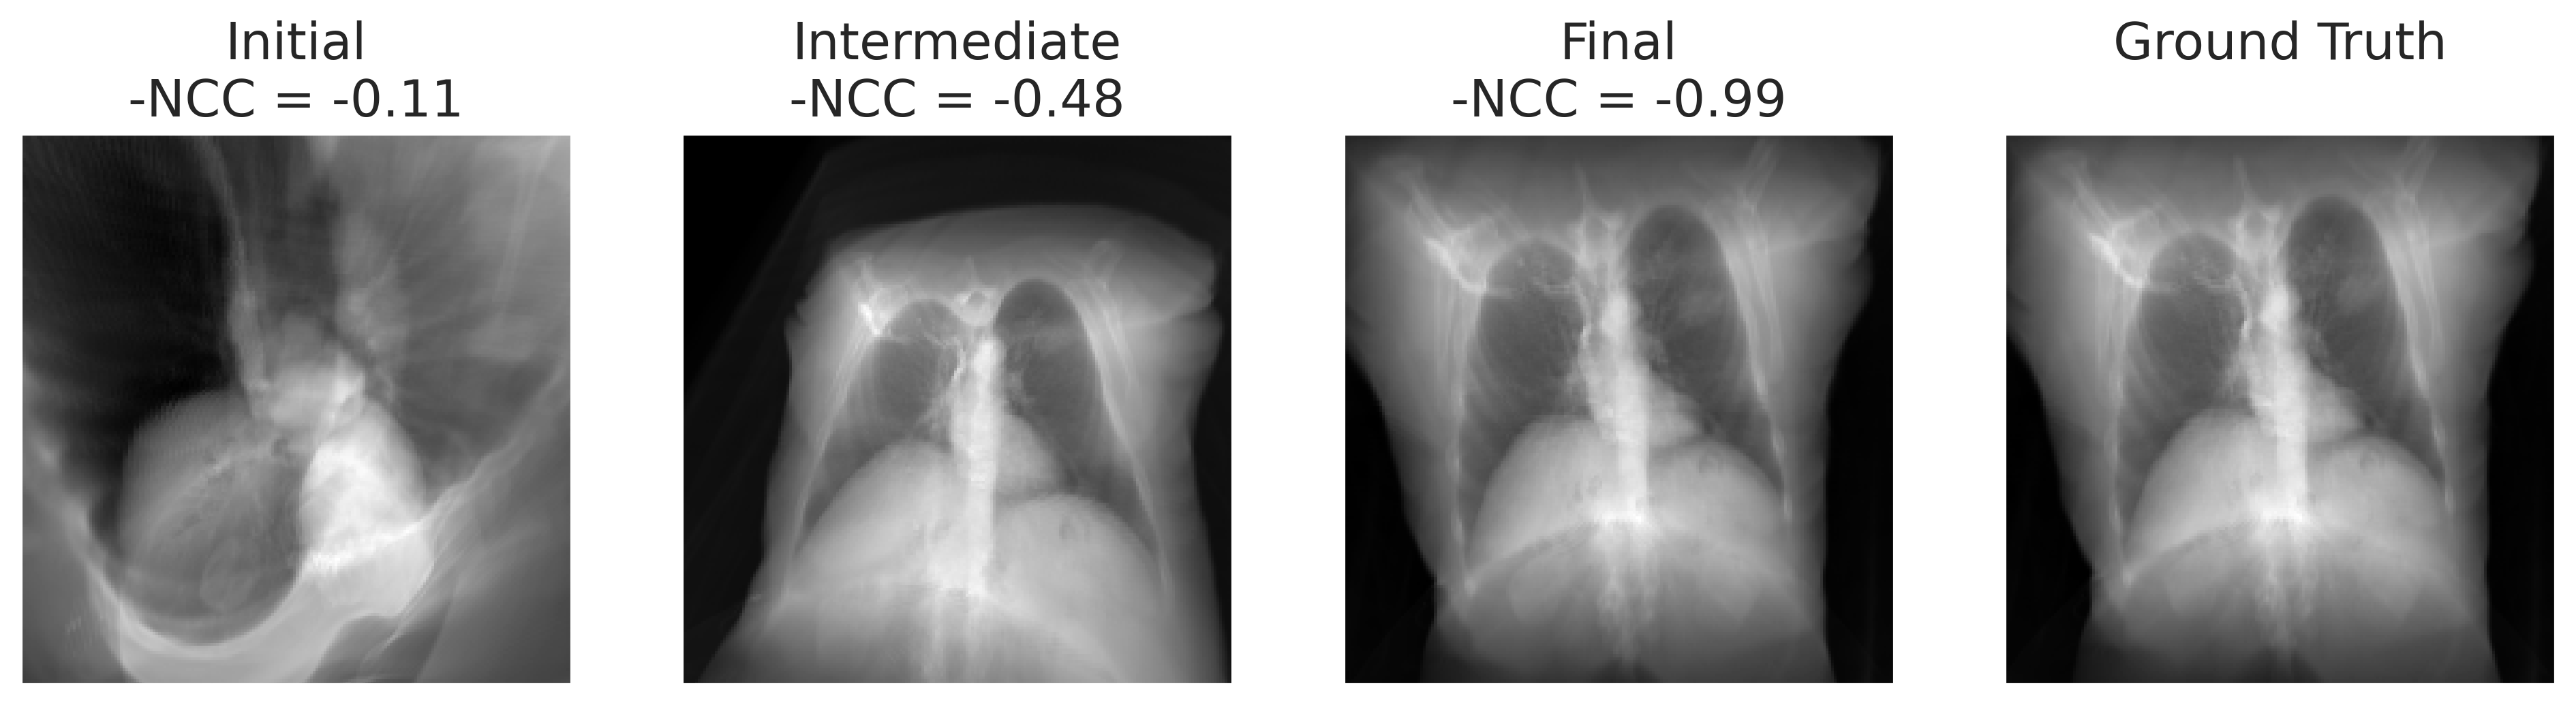

In [47]:
plot_est("../results/grad_desc/263.csv", 25, "../figures/converged-2.pdf")

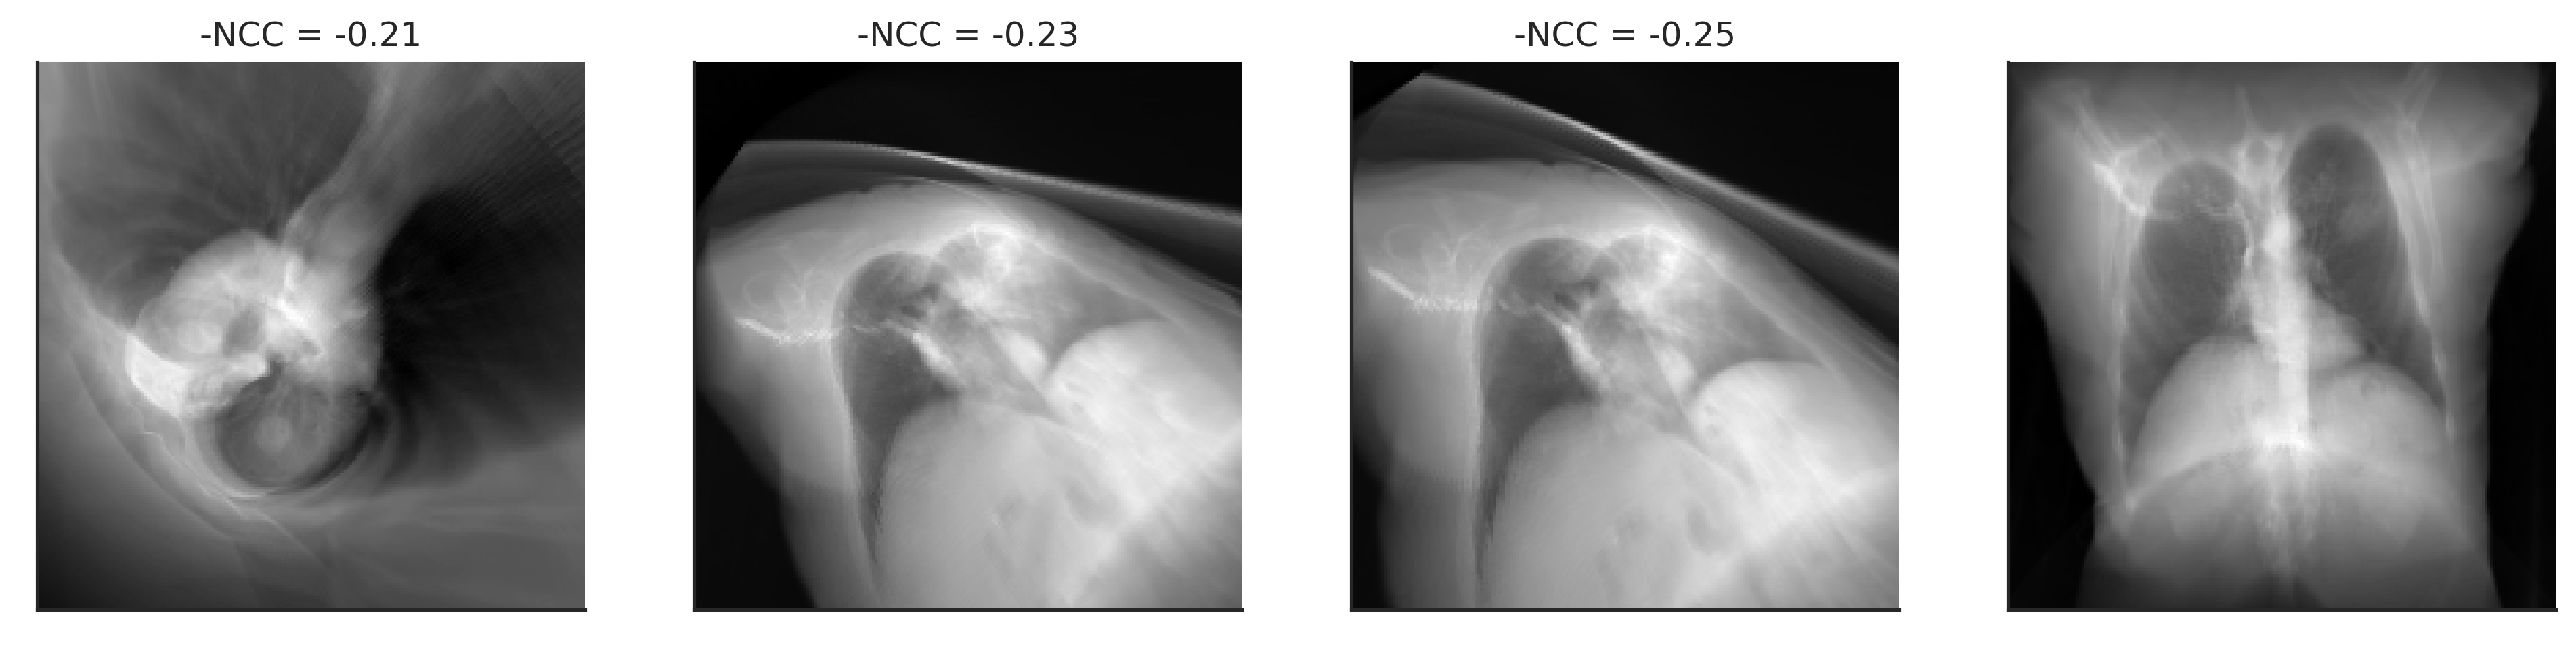

In [71]:
plot_est("../results/grad_desc/370.csv", 150, "../figures/case3.pdf")

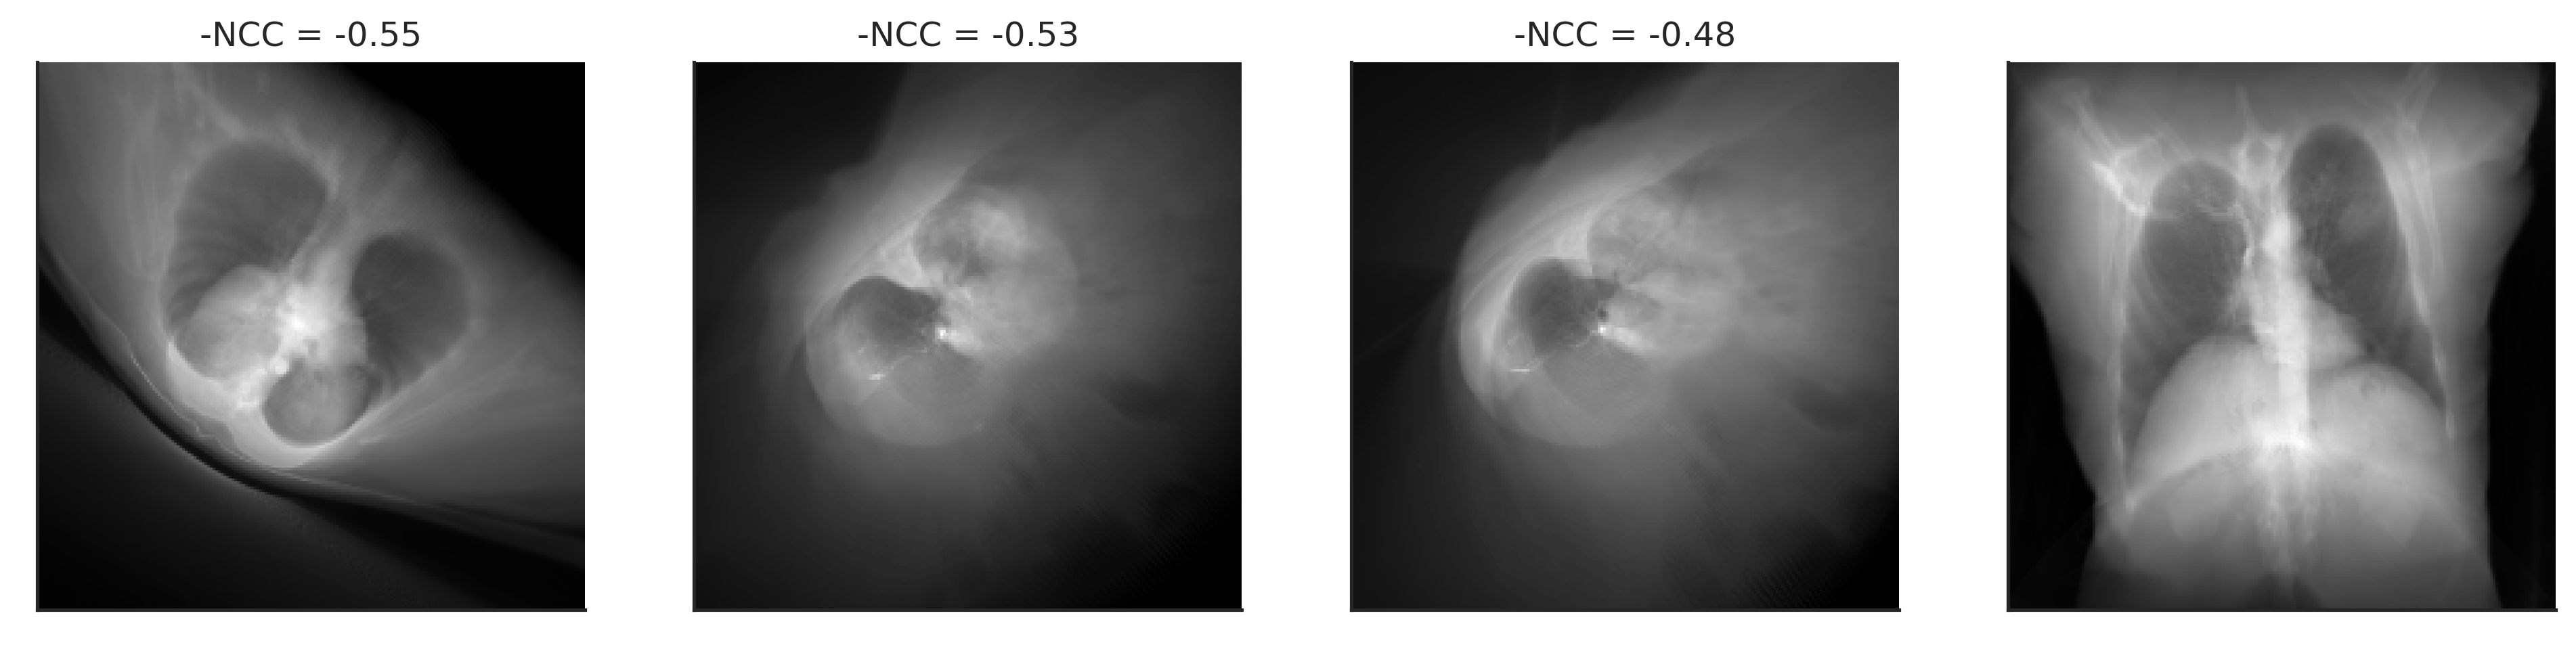

In [72]:
plot_est("../results/grad_desc/446.csv", 50, "../figures/case2.pdf")

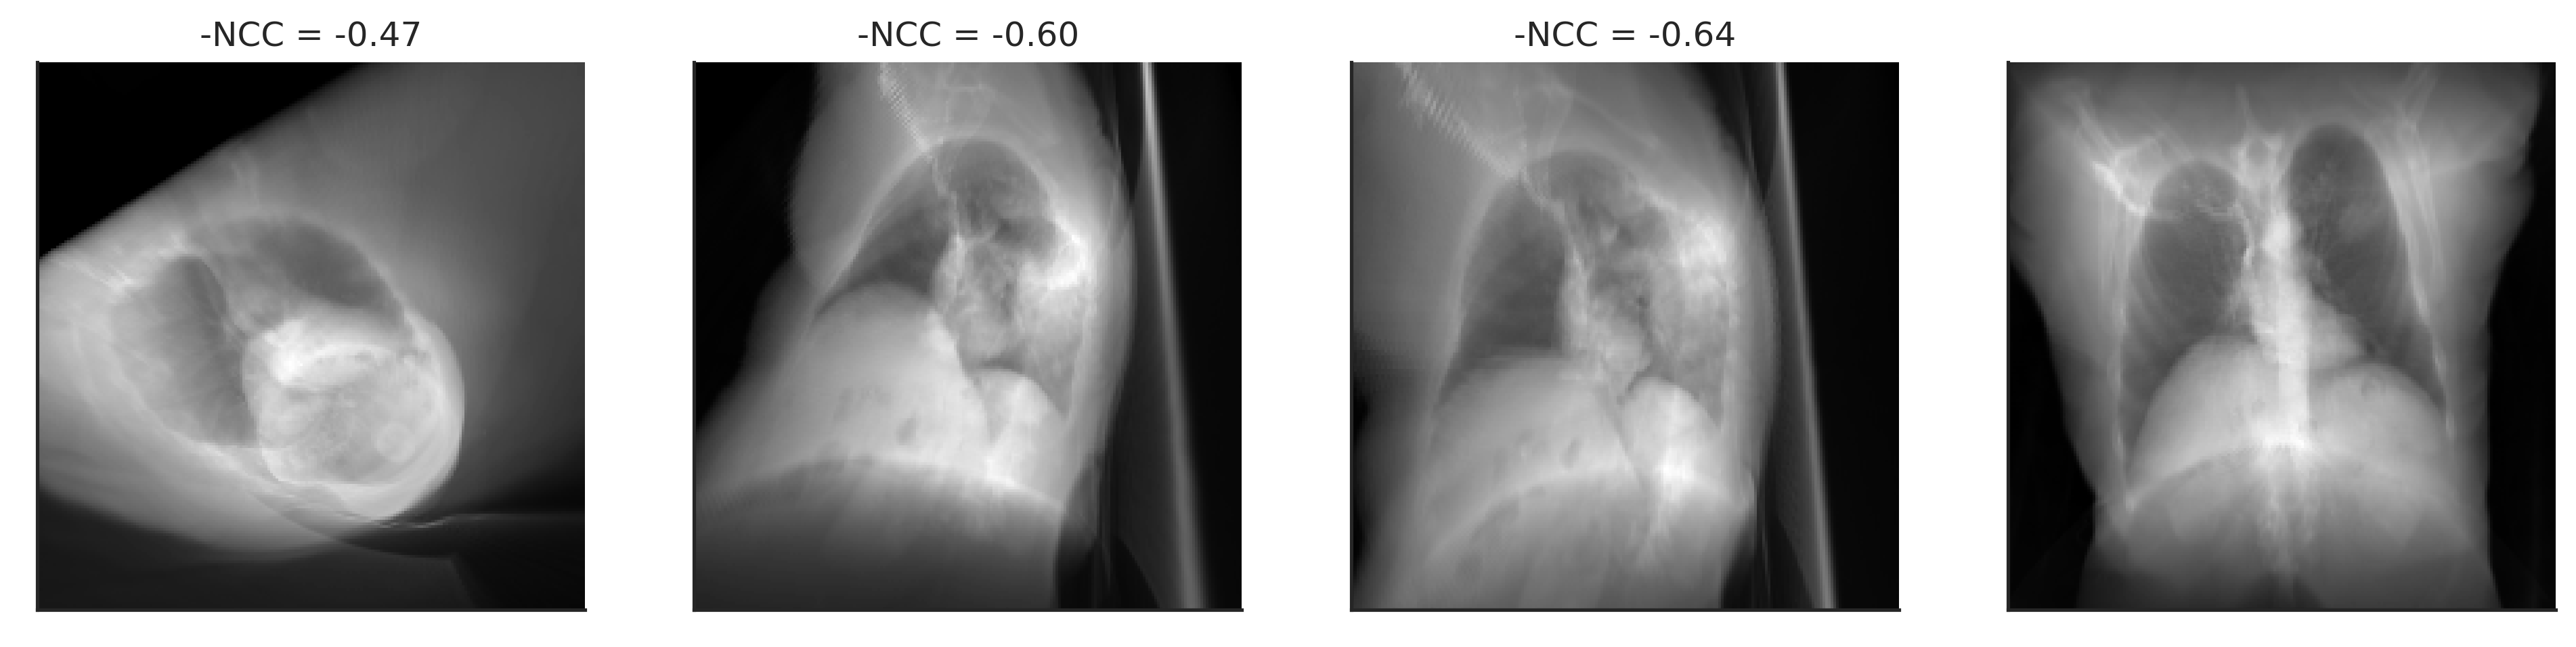

In [73]:
plot_est("../results/grad_desc/27.csv", 50, "../figures/case1-1.pdf")

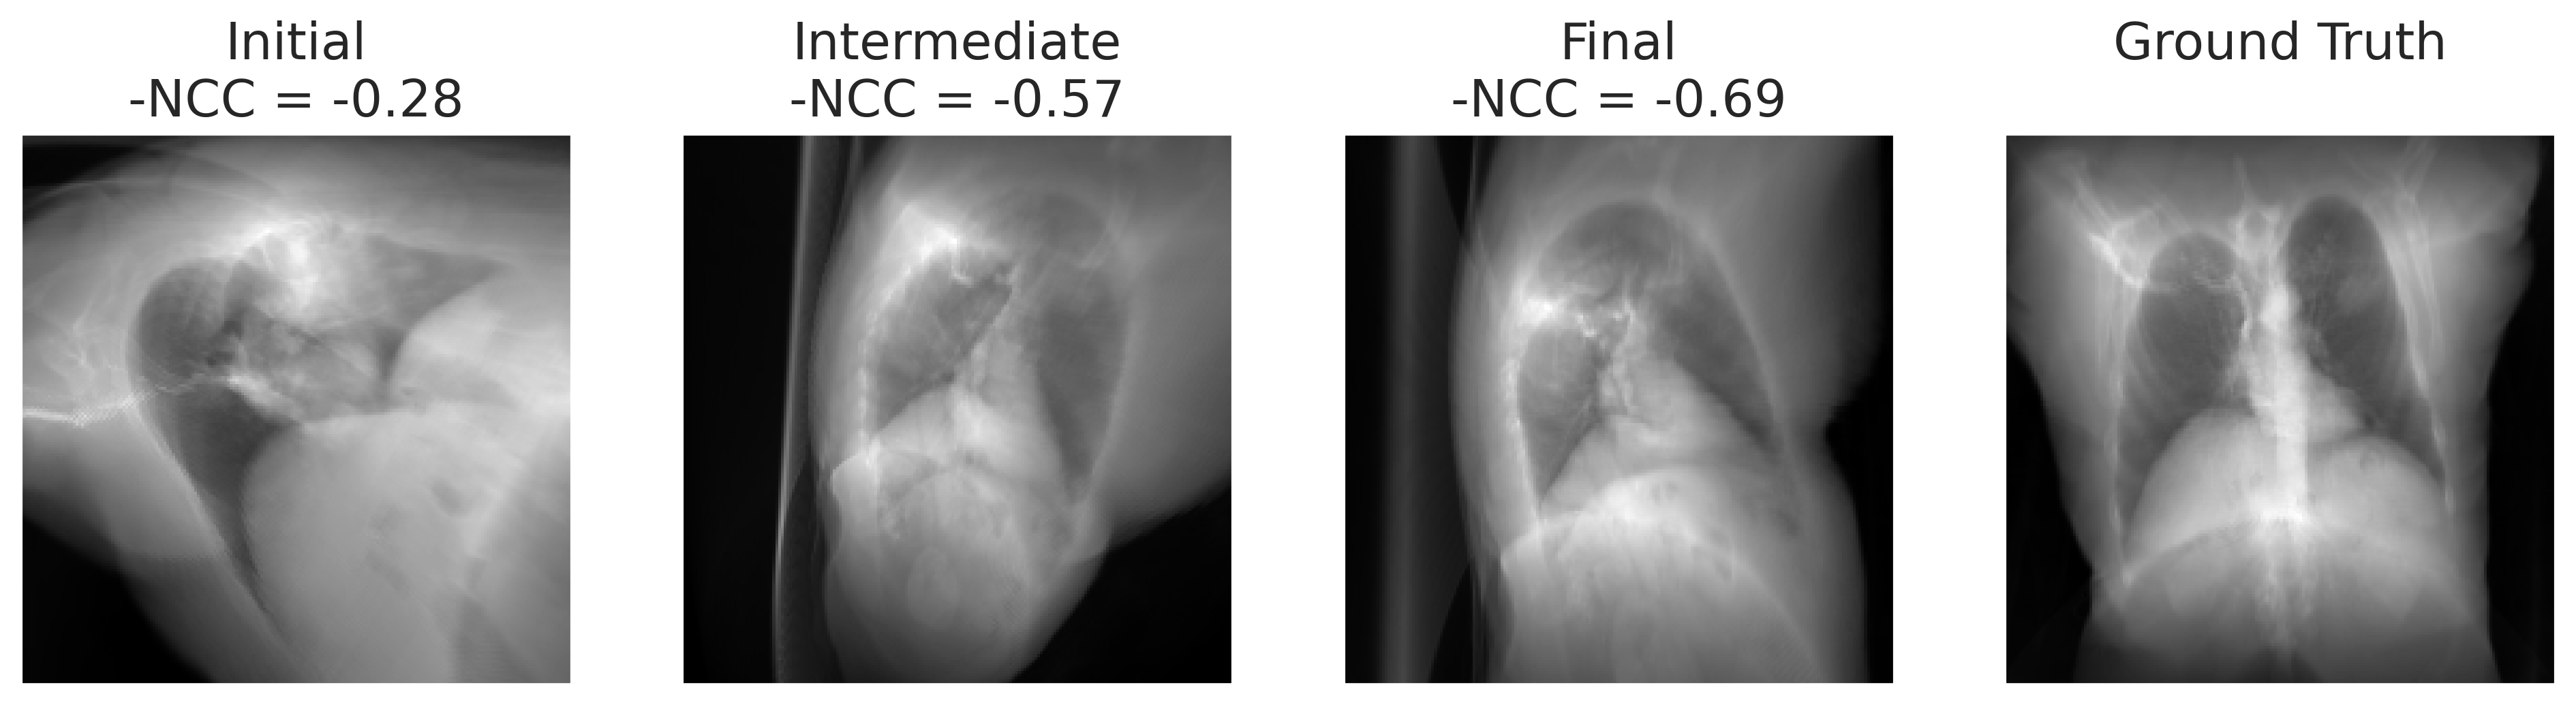

In [48]:
plot_est("../results/grad_desc/29.csv", 50, "../figures/case1-2.pdf")